In [1]:
using PyCall
unshift!(PyVector(pyimport("sys")["path"]), "");
@pyimport Compute_Jacobian_MA

In [2]:
numNodes = Compute_Jacobian_MA.numNodes;
numLinks = Compute_Jacobian_MA.numLinks;
numZones = Compute_Jacobian_MA.numZones;
numODpairs = Compute_Jacobian_MA.numODpairs;
od_pairs = Compute_Jacobian_MA.od_pairs;
link_list_js = Compute_Jacobian_MA.link_list_js;
link_length_list = Compute_Jacobian_MA.link_length_list;

In [3]:
require("prepare_data_MA.jl");
require("extract_data_MA.jl");
require("../Julia_files/tap_MSA.jl");
require("../Julia_files/inverseVI.jl");
require("../Julia_files/demands_adjustment_gradi.jl");

In [4]:
require("initia_data.jl");

In [5]:
demandsDiffDict[1] = norm(demandsDicToVec(demandsDict[1]) - demandsDicToVec(demandsDict[0]))/
                     norm(demandsDicToVec(demandsDict[0]));

In [6]:
fcoeffs = [1, 0, 0, 0, .15];

# get observed flow vector (corresponding to ground truth demands and ground truth costs)
tapFlowDicDict[0], tapFlowVecDict[0] = tapMSA(demandsDict[0], fcoeffs);

In [7]:
# get arcs data corresponding to ground truth demands and flows
arcsDict[0] = observFlow("./benchmark_data/East_Massachusetts_net_Apr_PM_ext.txt", tapFlowDicDict[0]);

In [8]:
deg = 6
c = 3.41
lam = 1.

coeffs_dict[(deg, c, lam, 1)], objInvVIDict[1] = train(lam, deg, c, demandsDict[1], arcsDict[0]);

In [9]:
# get initial flow vector (corresponding to initial demands)
tapFlowDicDict[1], tapFlowVecDict[1] = tapMSA(demandsDict[1], coeffs_dict[(deg, c, lam, 1)]);

demandsVecDict[0] = demandsDicToVec(demandsDict[0]);

In [10]:
demandsVecDict[1] = demandsDicToVec(demandsDict[1]);
objFunDict[1] = objF(demandsVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [11]:
# get arcs data corresponding to initial demands and flows
arcsDict[1] = observFlow("./benchmark_data/East_Massachusetts_net_Apr_PM_ext.txt", tapFlowDicDict[1]);

In [12]:
linkCostDicDict[1] = tapFlowVecToLinkCostDict(tapFlowVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [13]:
linkCostDicDict[1]["0"], link_length_list[1]

(6.025953273761397,6.0)

In [14]:
jacobiSpiessDict[1] = Compute_Jacobian_MA.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[1]["$(i)"] for i=0:numLinks-1]);

In [15]:
# maximum number of iterations
N = 50;  

# Armijo rule parameters
rho = 2;
M = 10;

# search direction parameter
epsilon_1 = 0;

# stop criterion parameter
epsilon_2 = 1e-20;

In [16]:
for l = 1:N
    
    jacobDict[l] = jacobiSpiessDict[l]

    descDirecDict[l] = descDirec(tapFlowVecDict[l], tapFlowVecDict[0], jacobDict[l], numODpairs, numLinks);

    demandsVecDict[l] = demandsDicToVec(demandsDict[l]);

    searchDirecDict[l] = searchDirec(demandsVecDict[l], descDirecDict[l], epsilon_1);

    thetaMaxDict[l] = thetaMax(demandsVecDict[l], searchDirecDict[l]);

    demandsVecDict[l+1] = similar(demandsVecDict[0]);
    
    demandsVecDict[l+1], objFunDict[l+1] = armijo(objFunDict[l], demandsVecDict[l], coeffs_dict[(deg, c, lam, l)], 
    searchDirecDict[l], thetaMaxDict[l], rho, M);
            
    demandsDict[l+1] = demandsVecToDic(demandsVecDict[l+1]);
    
    tapFlowDicDict[l+1], tapFlowVecDict[l+1] = tapMSA(demandsDict[l+1], coeffs_dict[(deg, c, lam, l)]);
        
    arcsDict[l+1] = observFlow("./benchmark_data/East_Massachusetts_net_Apr_PM_ext.txt", tapFlowDicDict[l+1]);
        
    coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[0]);

    linkCostDicDict[l+1] = tapFlowVecToLinkCostDict(tapFlowVecDict[l+1], coeffs_dict[(deg, c, lam, l+1)]);
    
    jacobiSpiessDict[l+1] = Compute_Jacobian_MA.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[l+1]["$(i)"] for i=0:numLinks-1]);
        
    demandsDiffDict[l+1] = norm(demandsVecDict[l+1] - demandsVecDict[0]) / norm(demandsVecDict[0]);
    
    # stopping criterion
    if (objFunDict[l] - objFunDict[l+1]) / objFunDict[1] < epsilon_2
        break
    end
        
end

# normalize objective function value
for l = 1:(length(objFunDict))
    norObjFunDict[l] = objFunDict[l] / objFunDict[1];
end

In [17]:
demandsVecDict

Dict{Int64,Array{Float64,1}} with 14 entries:
  2  => [94.21667738988592,111.18588513106488,448.6155988553086,215.610001769116…
  11 => [81.696012859909,112.86128091721858,451.1417700055678,213.63048981220916…
  0  => [100.0,100.0,500.0,200.0,300.0,500.0,800.0,500.0,1300.0,500.0,200.0,500.…
  7  => [81.69763054999231,112.86104998264803,451.1412835606681,213.630448413160…
  9  => [81.69658292359654,112.8611977082574,451.14159749950727,213.630475482706…
  10 => [81.69602323856637,112.86127950539661,451.14176683884676,213.63048935506…
  8  => [81.69735291424168,112.86109220041514,451.1413690250435,213.630456352751…
  6  => [83.23060018057258,112.43651916567292,450.5072243687146,213.503330756802…
  4  => [92.39283548648682,111.2031093770934,448.5296902216746,214.7654647230506…
  3  => [94.0377784203882,111.21053511809995,448.6212987417816,215.5241828951096…
  5  => [85.61210456885708,111.56712357670038,448.9513053665282,212.556529611576…
  13 => [81.69584696325813,112.86130348433109,451.14

In [18]:
norObjFunDict

Dict{Int64,Float64} with 13 entries:
  2  => 0.6641407650548434
  11 => 0.35771515979136165
  7  => 0.3610689525662943
  9  => 0.3583297531280543
  10 => 0.3577154499809639
  8  => 0.358465573596865
  6  => 0.37914993156212334
  4  => 0.5076897776660034
  3  => 0.5761584698463236
  5  => 0.41361178894045214
  13 => 0.3575918199015781
  12 => 0.3575918199015781
  1  => 1.0

INFO: Loading help data...


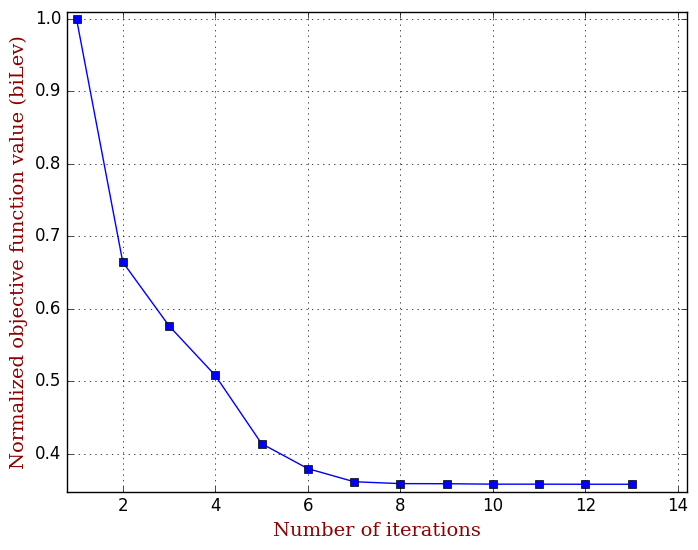

In [19]:
using PyPlot

iterNum = 1:(length(norObjFunDict))

objFun = map(iterNum->norObjFunDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, length(norObjFunDict) + 1 + .2)
ylim(minimum(objFun)-.01, maximum(objFun)+.01)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized objective function value (biLev)", fontdict=font1)

savefig("./results/objFun_biLev_MA.pdf")

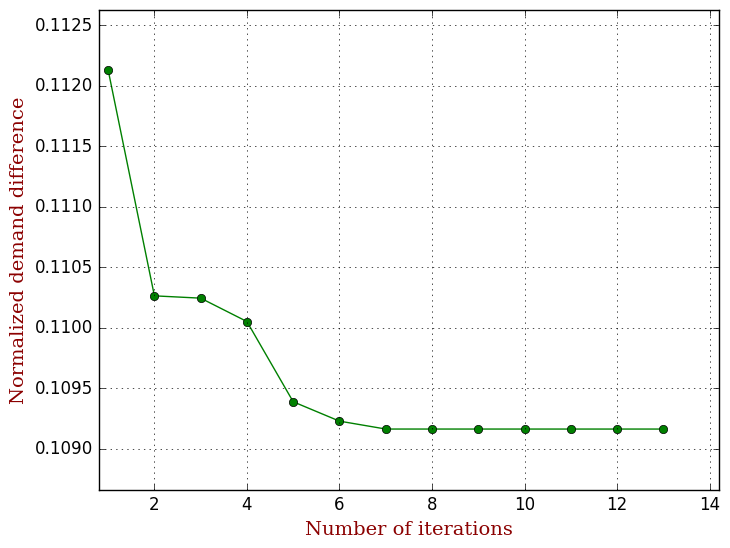

In [20]:
using PyPlot

iterNum = 1:(length(demandsDiffDict))

demandsDiff = map(iterNum->demandsDiffDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, demandsDiff, "o-g")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, length(demandsDiffDict) + 1 + .2)
ylim(minimum(demandsDiff)-.0005, maximum(demandsDiff)+.0005)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized demand difference", fontdict=font1)

savefig("./results/demandsDiff_biLev_MA.pdf")

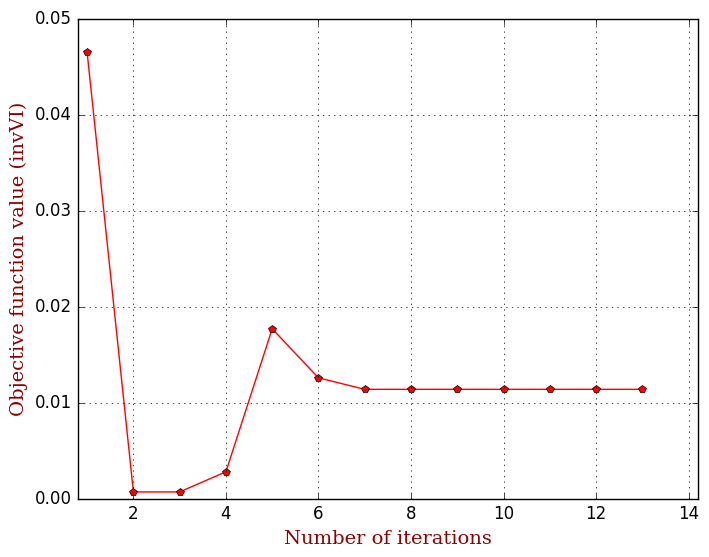

In [21]:
using PyPlot

iterNum = 1:(length(objInvVIDict))

objFun = map(iterNum->objInvVIDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "p-r")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(0.8, length(objInvVIDict) + 1 + .2)
# ylim(0.9, 2.0)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Objective function value (invVI)", fontdict=font1)

savefig("./results/objFun_invVI_MA.pdf")

In [22]:
coeffs_dict

Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}} with 13 entries:
  (6,3.41,1.0,6)  => [1.0,0.00880448611921326,-0.04869293851648602,0.06251076505…
  (6,3.41,1.0,11) => [1.0,0.008030904091151286,-0.04627534287671945,0.0618293865…
  (6,3.41,1.0,13) => [1.0,0.007964365941630053,-0.046065515868738506,0.061760978…
  (6,3.41,1.0,3)  => [1.0,-0.019160487540003265,0.028374094906566324,0.086098134…
  (6,3.41,1.0,10) => [1.0,0.008089981519347103,-0.04645849947665191,0.0618870743…
  (6,3.41,1.0,8)  => [1.0,0.008101673576422172,-0.04650054012458707,0.0619105203…
  (6,3.41,1.0,9)  => [1.0,0.008089782810086142,-0.046460721841683324,0.061891313…
  (6,3.41,1.0,5)  => [1.0,0.015540792344764987,-0.0699449314061715,0.06939470436…
  (6,3.41,1.0,12) => [1.0,0.007964365941630053,-0.046065515868738506,0.061760978…
  (6,3.41,1.0,2)  => [1.0,-0.0206552514846566,0.033102151762629345,0.08465881211…
  (6,3.41,1.0,7)  => [1.0,0.008039206554166633,-0.04630298326269463,0.0618443729…
  (6,3.41,1.0,4)  => [1.0,0.

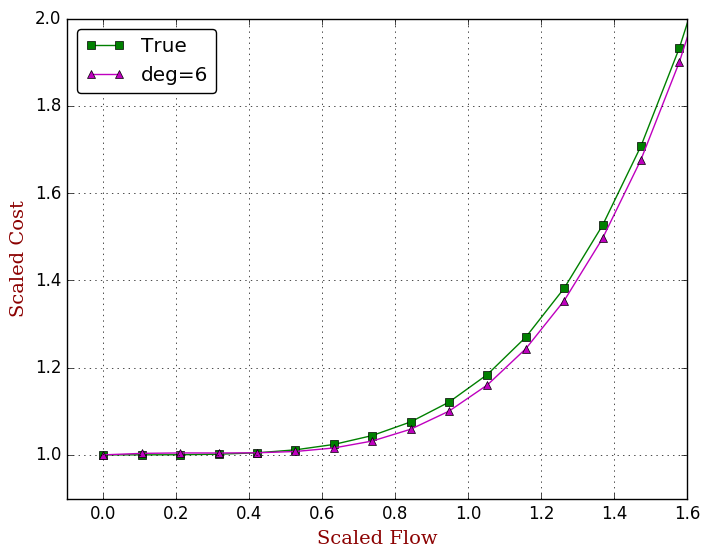

In [23]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_MA_iter_$(iterN).pdf")

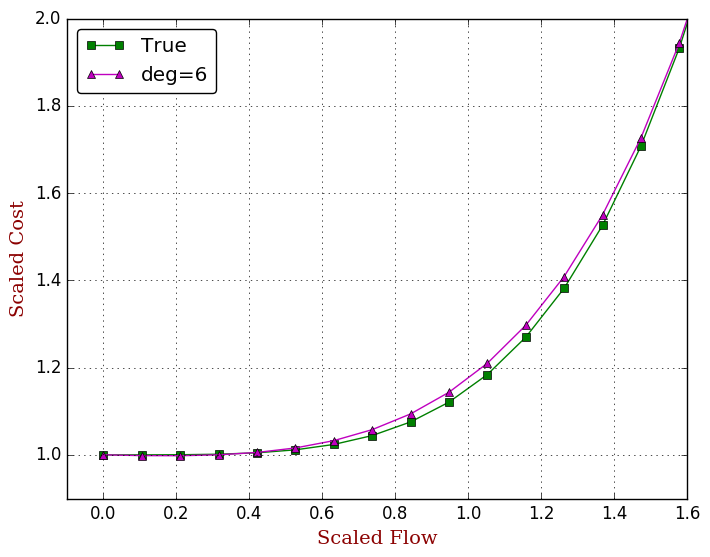

In [24]:
using PyPlot

iterN = 2

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_MA_iter_$(iterN).pdf")

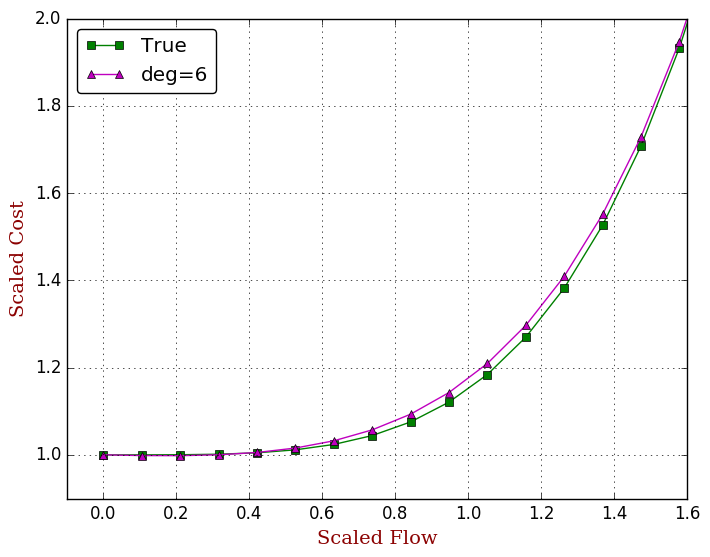

In [25]:
using PyPlot

iterN = 3

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_MA_iter_$(iterN).pdf")

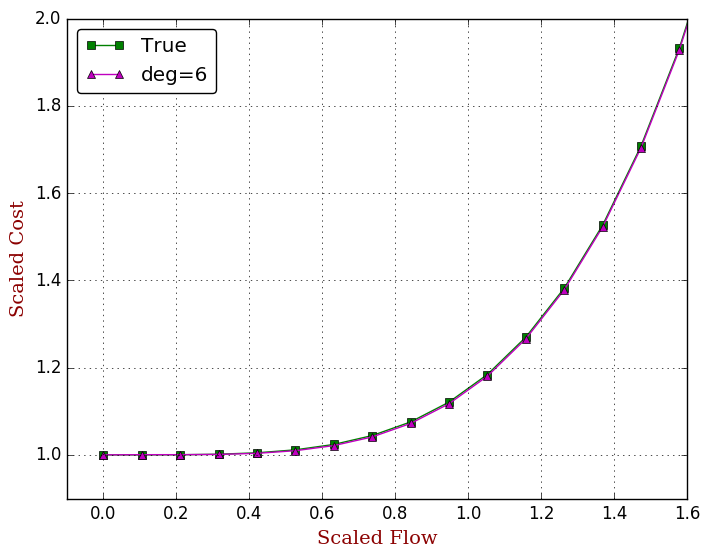

In [26]:
using PyPlot

iterN = length(coeffs_dict)

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_MA_iter_$(iterN).pdf")

In [27]:
outfile = open("./results/norObjFunDict.json", "w")

JSON.print(outfile, norObjFunDict)

close(outfile)

In [28]:
outfile = open("./results/demandsDiffDict.json", "w")

JSON.print(outfile, demandsDiffDict)

close(outfile)

In [29]:
outfile = open("./results/objInvVIDict.json", "w")

JSON.print(outfile, objInvVIDict)

close(outfile)

In [30]:
outfile = open("./results/coeffs_dict.json", "w")

JSON.print(outfile, coeffs_dict)

close(outfile)

In [31]:
outfile = open("./results/demandsVecDict.json", "w")

JSON.print(outfile, demandsVecDict)

close(outfile)

In [32]:
outfile = open("./results/demandsDict.json", "w")

JSON.print(outfile, demandsDict)

close(outfile)

In [33]:
outfile = open("./results/tapFlowDicDict.json", "w")

JSON.print(outfile, tapFlowDicDict)

close(outfile)

In [34]:
outfile = open("./results/tapFlowVecDict.json", "w")

JSON.print(outfile, tapFlowVecDict)

close(outfile)